In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms


def conv3x3(in_channels: int, out_channels: int):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                     kernel_size=3, padding=1)

def max_pool_2d():
    return nn.MaxPool2d(kernel_size=2, stride=2)
  
class VGGlayer(nn.Module):
  
  def __init__(self, in_channels: int, out_channels: int, activated=True, 
              max_pool = False):
        super(VGGlayer, self).__init__()
      
        layers = [
            conv3x3(in_channels, out_channels),
            # nn.BatchNorm2d(out_channels),
            
        ] 

        if activated:
          layers += [nn.ReLU()]
        
        if max_pool:
          layers += [max_pool_2d()]
          
        self.layer = nn.Sequential(*layers)
  
  def forward(self, x):
      return self.layer(x)


class VGG16(nn.Module):

    def __init__(self, in_channels: int = 3, num_classes: int = 1000):
        super(VGG16, self).__init__()

        self.conv_features = nn.Sequential(
            VGGlayer(in_channels, 64),
            VGGlayer(64, 64, max_pool=True),
            VGGlayer(64, 128),
            VGGlayer(128, 128, max_pool=True),
            VGGlayer(128, 256),
            VGGlayer(256, 256),
            VGGlayer(256, 256, max_pool=True),
            VGGlayer(256, 512),
            VGGlayer(512, 512),
            VGGlayer(512, 512, max_pool=True),
            VGGlayer(512, 512),
            VGGlayer(512, 512),
            VGGlayer(512, 512, max_pool=True),
            
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    
    def forward(self, x):
        x = self.conv_features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

ModuleNotFoundError: No module named 'torch.utils.model_zoo'

In [2]:
import numpy as np

net = VGG16()
num_params = sum([np.prod(p.shape) for p in net.parameters()])
print(f"Number of parameters : {num_params}")
print('-'*50)

# test on Imagenet-like shaped data

X = torch.rand((8, 3, 224, 224))
print('output shape for imgnet', net(X).shape)


Number of parameters : 138357544
--------------------------------------------------
output shape for imgnet torch.Size([8, 1000])


In [3]:
# test on CIFAR-like shaped data

X = torch.rand((8, 3, 32, 32))
print('output shape for cifar', net(X).shape)
net(X)

output shape for cifar torch.Size([8, 1000])


tensor([[ 2.0439e-02,  2.0144e-02, -8.4204e-03,  ...,  2.6267e-03,
         -2.8267e-03, -2.2514e-03],
        [ 1.0710e-02,  5.3385e-03, -8.2920e-03,  ...,  7.6924e-03,
         -1.4283e-03,  5.5084e-04],
        [ 1.1539e-02,  1.1755e-02, -1.4161e-02,  ...,  5.5298e-03,
         -8.7296e-03, -4.5281e-03],
        ...,
        [ 1.6756e-02,  2.5607e-02,  1.9996e-03,  ...,  7.6521e-03,
         -9.7851e-03, -2.7087e-05],
        [ 2.0321e-02,  1.7600e-02, -7.1086e-03,  ...,  4.0290e-03,
         -6.4623e-04, -4.6635e-03],
        [ 1.1763e-02,  1.2935e-02, -1.0978e-02,  ...,  3.9324e-03,
         -4.0918e-03,  2.7812e-03]], grad_fn=<AddmmBackward0>)

In [4]:
import torchvision
import torchvision.transforms as transforms

mean = (0.4913997551666284, 0.48215855929893703, 0.4465309133731618)
std  = (0.24703225141799082, 0.24348516474564, 0.26158783926049628)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


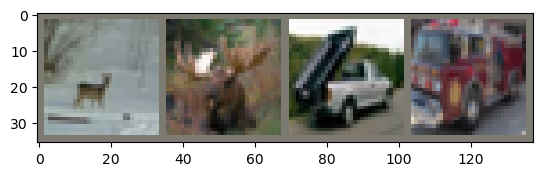

 deer  deer truck truck


In [5]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img * np.array(std)[:,None,None] + np.array(mean)[:,None,None] # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
assert torch.cuda.is_available(), "Notebook is not configured properly!"
device = 'cuda:0'

net = VGG16(num_classes=10).to(device)

# Nothing works w/o Batch Norm or Proper Initialization
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

initialize_weights(net)
crit = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
epochs = 10
print(torch.cuda.get_device_name())

/homes/acastagni/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


AssertionError: Notebook is not configured properly!

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print(f"CUDA is available. Using device: {torch.cuda.get_device_name(device)}")
else:
    device = 'cpu'
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [ ]:
from datetime import datetime
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt

now = datetime.now()
train_name = f'{now.hour}:{now.minute}:{now.second}/'
for e in range(epochs):
    pbar = tqdm(total=len(trainloader), desc=f'Epoch {e} - 0%')
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        y_pred = net(x)
        loss = crit(y_pred, y)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        pbar.update(1)
        pbar.set_description(f'Epoch {e} - {round(i/len(trainloader) * 100)}% -- loss {loss.item():.2f}')

    with torch.no_grad():
        corr = 0
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = net(x)
            corr += (torch.max(y_pred, 1)[1] == y).sum()
    print(f"Accuracy for epoch {e}:{corr / len(testset)}")

NameError: name 'epochs' is not defined